# intel-image-classification-project

<img src="https://storage.googleapis.com/kaggle-datasets-images/111880/269359/a16c143f44e79d17f54d5e670f16e03b/dataset-cover.jpg?t=2019-02-01-19-30-12" style="max-width:480px">
Use the "Run" button to execute the code.


In [ ]:
import os
import opendatasets as od
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Exploring the Dataset

### Context
This is image data of Natural Scenes around the world.

### Content
This Data contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }
<img src="https://miro.medium.com/max/1400/1*tyGmirZbPUJMAYP2RkdrkQ.png" style="max-width:480px">




In [ ]:
od.download('https://www.kaggle.com/datasets/puneet6060/intel-image-classification')

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [ ]:
os.listdir('intel-image-classification/')

['seg_train', 'seg_test', 'seg_pred']

In [ ]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.Resize((64,64)),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.Resize((64,64)),
                       tt.ToTensor(),
                       tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder('intel-image-classification/seg_train/seg_train', train_tfms)
test_ds = ImageFolder('intel-image-classification/seg_test/seg_test', test_tfms)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
    for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(denormalize(images, *stats)[:32], nrow=8).permute(1, 2, 0).clamp(0, 1))
      return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


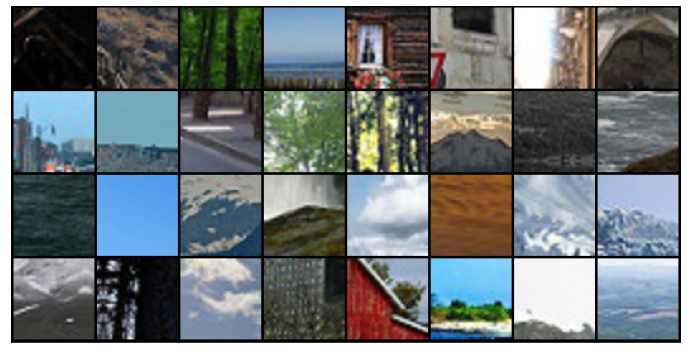

In [ ]:
show_batch(train_dl)

## GPU Utilities and Training Loop

To seamlessly use a GPU, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU.

In [ ]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl= dl
        self.device= device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
          yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model with Residual Blocks and Batch Normalization

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
ResNet9 = to_device(ResNet9(3, len(train_ds.classes)), device)
ResNet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(ResNet9, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1865234375, 'val_loss': 1.788785696029663}]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, ResNet9, train_dl, test_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00394, train_loss: 1.5377, val_loss: 1.5939, val_acc: 0.3548


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00935, train_loss: 1.5079, val_loss: 1.3714, val_acc: 0.4417


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00972, train_loss: 1.4564, val_loss: 1.0843, val_acc: 0.5945


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00812, train_loss: 1.2616, val_loss: 0.9053, val_acc: 0.6738


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00556, train_loss: 1.1788, val_loss: 0.9283, val_acc: 0.6310


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00283, train_loss: 1.1082, val_loss: 0.7754, val_acc: 0.7070


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00077, train_loss: 1.0490, val_loss: 0.7311, val_acc: 0.7222


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00000, train_loss: 0.9962, val_loss: 0.7071, val_acc: 0.7378
CPU times: user 13min 5s, sys: 10min 33s, total: 23min 38s
Wall time: 24min 20s


## Pretrained Model (ResNet34)

In [ ]:
from torchvision import models

class Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
ResNet34 = Model(len(train_ds.classes))
to_device(ResNet34, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history1 = [evaluate(ResNet34, test_dl)]
history1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1882440447807312, 'val_loss': 2.3320136070251465}]

In [ ]:
%%time
history1 += fit_one_cycle(epochs, max_lr, ResNet34, train_dl, test_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00394, train_loss: 1.1832, val_loss: 3.0470, val_acc: 0.2779


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00935, train_loss: 1.4655, val_loss: 1.1449, val_acc: 0.5700


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00972, train_loss: 1.3656, val_loss: 1.1043, val_acc: 0.5348


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00812, train_loss: 1.2495, val_loss: 1.2423, val_acc: 0.5286


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00556, train_loss: 1.1841, val_loss: 1.0846, val_acc: 0.5802


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00283, train_loss: 1.1166, val_loss: 0.8133, val_acc: 0.6992


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00077, train_loss: 1.0584, val_loss: 0.7928, val_acc: 0.7185


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00000, train_loss: 0.9980, val_loss: 0.7630, val_acc: 0.7198
CPU times: user 4min 26s, sys: 1min 54s, total: 6min 20s
Wall time: 7min 12s


## Testing with individual images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: buildings , Predicted (ResNet9): buildings , Predicted (ResNet34): buildings


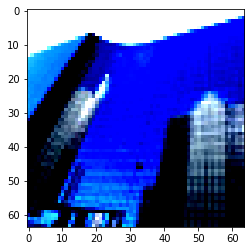

In [ ]:
img, label = test_ds[87]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted (ResNet9):', predict_image(img, ResNet9), ', Predicted (ResNet34):', predict_image(img, ResNet34))

Label: forest , Predicted (ResNet9): forest , Predicted (ResNet34): forest


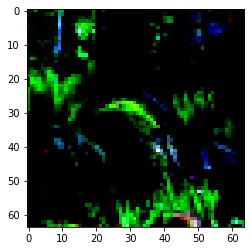

In [ ]:
img, label = test_ds[647]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted (ResNet9):', predict_image(img, ResNet9), ', Predicted (ResNet34):', predict_image(img, ResNet34))

Label: glacier , Predicted (ResNet9): glacier , Predicted (ResNet34): sea


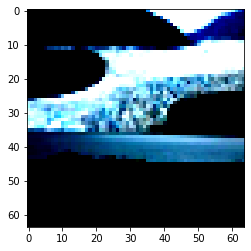

In [ ]:
img, label = test_ds[974]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted (ResNet9):', predict_image(img, ResNet9), ', Predicted (ResNet34):', predict_image(img, ResNet34))

Label: sea , Predicted (ResNet9): sea , Predicted (ResNet34): sea


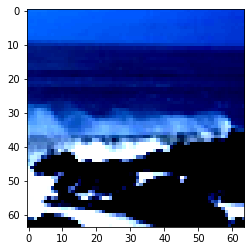

In [ ]:
img, label = test_ds[2298]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted (ResNet9):', predict_image(img, ResNet9), ', Predicted (ResNet34):', predict_image(img, ResNet34))

Label: forest , Predicted (ResNet9): mountain , Predicted (ResNet34): mountain


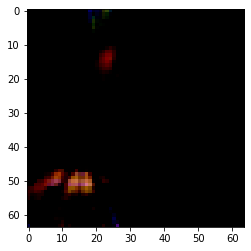

In [ ]:
img, label = test_ds[449]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted (ResNet9):', predict_image(img, ResNet9), ', Predicted (ResNet34):', predict_image(img, ResNet34))

## Inferences and Conclusion

In conclusion, we arrived at just over 70% accuracy in predicting the test dataset. However, we could achieve a higher accuracy if we had a stronger GPU to develop a more complex model.

## References and Future Work

> - You can find the dataset on this page: [Here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
> - [Jovian](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms) learning content has helped me a lot.
> - We can try training the models with more epoche.